# Synthetic Data on Healthcare

This notebook is a demonstration on how to use SQLSynthGen for generating synthetic data, for a healthcare use case.

## Initial Setup

In [247]:
%load_ext autoreload
%autoreload 2

from os import chdir

HOME_DIRECTORY: str = "/home/jovyan"

chdir(HOME_DIRECTORY)

import seaborn as sns
from lib import healthcare_demo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## De-Identification

Let's take a look at what's stored in the database. The `dataset` column has a value of `1` for patients with liver disease, and a value of `2` for no disease.

Notice no name, address, phone-number or email address are part of the data included.

In [248]:
import pandas as pd

DATABASE_NAME: str = "db"

connection, _ = healthcare_demo.connect_to_postgress(DATABASE_NAME)
patient_data = pd.read_sql_query(
    "SELECT * FROM indian_liver_patient", con=connection
)

patient_data

/tmp/ipykernel_497/878618893.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patient_data = pd.read_sql_query(


,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1,2
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1,4
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2,579
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1,580
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1,581
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1,582


# Linkage Attacks

Let us image we have a target that we now was part of this study, that does not want us to know their results. 

Let us also imagine that we know the target has 44 years old.

In [249]:
TARGET_AGE: int = 44
patient_data.query(f"age == {TARGET_AGE}")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
171,44,Female,1.9,0.6,298,378,602,6.6,3.3,1.0,1,172
257,44,Male,0.8,0.2,335,148,86,5.6,3.0,1.1,1,258
316,44,Male,0.9,0.2,182,29,82,7.1,3.7,1.0,2,317


Now we know that there's a **2/3 probability** that this target has liver disease. Now, let us consider we receive additional information about their `gender`:

In [250]:
TARGET_GENDER: str = "Female"
patient_data.query(f"age == {TARGET_AGE} and gender == '{TARGET_GENDER}'")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
171,44,Female,1.9,0.6,298,378,602,6.6,3.3,1.0,1,172


We have learned **against the target's will** that she has liver disease. Now, let's check how many people can we identify if we only know their age:


Text(0, 0.5, 'Number of occurrences')

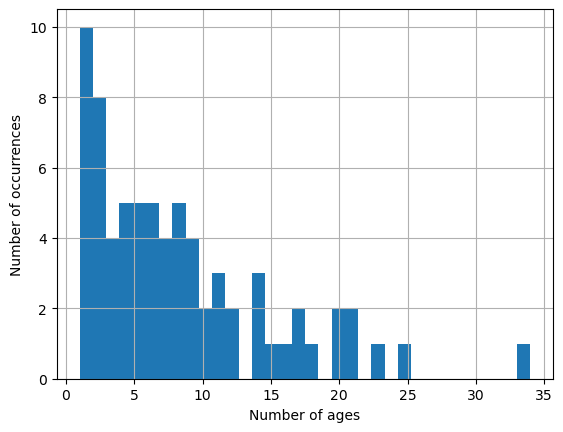

In [251]:
import matplotlib.pyplot as plt

age_counts: pd.DataFrame = patient_data["age"].value_counts()
NUMBER_OF_BINS: int = max(age_counts)

age_counts.hist(bins=NUMBER_OF_BINS)
plt.xlabel("Number of ages")
plt.ylabel("Number of occurrences")


## Aggregation

To avoid this situations, a common approach is to only release aggregate information. For example, let's release the average `albumin` per age group:

In [252]:
import numpy as np

age_and_albumin: pd.DataFrame = patient_data[["age", "albumin"]]

albumin_per_age_group: pd.DataFrame = age_and_albumin.groupby(
    pd.cut(patient_data["age"], np.arange(0, 95, 5))
).mean()

albumin_per_age_group

,age,albumin
age,,
"(0, 5]",4.000000,3.600000
"(5, 10]",7.600000,3.040000
"(10, 15]",13.000000,3.960000
"(15, 20]",17.875000,3.395833
"(20, 25]",22.724138,3.634483
"(25, 30]",27.844444,3.320000
"(30, 35]",32.936508,3.225397
"(35, 40]",38.140625,3.314062
"(40, 45]",43.379310,3.050000


Now, the average age for group `(75, 80]` corresponds to the age of a single patient, and we are actually revealing his albumin results.

In [253]:
average_age: float = 78.0
patient_data.query(f"age == {average_age}")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
397,78,Male,1.0,0.3,152,28,70,6.3,3.1,0.9,1,398


## Differencing Attacks

Let us imagine that our fictional target hasn't participated in the study yet. And that the researchers release total `albumin` per gender daily:

In [254]:
patient_data_without_target: pd.DataFrame = patient_data.query(
    f"age != {TARGET_AGE} or gender != '{TARGET_GENDER}'"
)

healthcare_demo.get_albumin_per_gender(patient_data_without_target)

,albumin
gender,
Female,461.5
Male,1366.9


Our target attends to the study, and inmediatly the researchers do their daily release:

In [255]:
healthcare_demo.get_albumin_per_gender(patient_data)

,albumin
gender,
Female,464.8
Male,1366.9


Now, we can easily obtain our target's albumin by `464.8 - 461.5 = 3.3`.

## K-Anonimity

Let's check for what values of `k` our dataset holds `k-anonymity`. For demonstration purposes, we consider `age`, `gender`, and `dataset` as quasi-identifiers:

In [256]:
QUASI_IDENTIFIERS: str = ["age", "gender", "dataset"]

print(
    healthcare_demo.is_k_anonymized(
        patient_data, k_value=1, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

True


However, k-anonimity of `2` can be challenging:

In [257]:
print(
    healthcare_demo.is_k_anonymized(
        patient_data, k_value=2, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

False


## Generalising the Data

We can attempt to reach k-anoninimity for `k=2` by rounding age to the nearest 10 years:

In [258]:
generalised_patient_data: pd.DataFrame = patient_data.copy()
generalised_patient_data["age"] = generalised_patient_data["age"].round(-1)

generalised_patient_data

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
0,60,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1,1
1,60,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1,2
2,60,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3
3,60,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1,4
4,70,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2,579
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1,580
580,50,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1,581
581,30,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1,582


Now, let's try again and see if we satisfy k-anonimity for `k=2`:

In [259]:
print(
    healthcare_demo.is_k_anonymized(
        generalised_patient_data, k_value=2, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

False


Outliers might be reason behind this:

Text(0, 0.5, 'Number of occurrences')

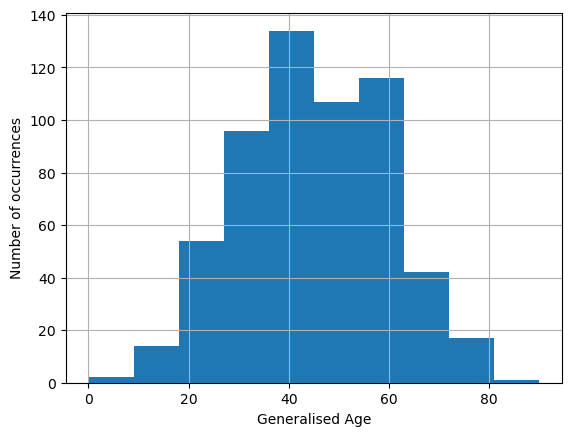

In [260]:
generalised_patient_data["age"].hist()
plt.xlabel("Generalised Age")
plt.ylabel("Number of occurrences")


Let's attempt clipping to see if we can achieve k-anonimity for `k=2`:

In [261]:
maximum_age: int = 80
clipped_age_data: pd.DataFrame = healthcare_demo.clip_column(
    data=patient_data, column="age", maximum=maximum_age
)

print(
    healthcare_demo.is_k_anonymized(
        clipped_age_data, k_value=2, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

False


Still...no luck. What if we also generalise:

In [262]:
clipped_and_generalised: pd.DataFrame = clipped_age_data.copy()
clipped_and_generalised["age"] = clipped_and_generalised["age"].round(-1)

print(
    healthcare_demo.is_k_anonymized(
        clipped_and_generalised, k_value=2, quasi_identifiers=QUASI_IDENTIFIERS
    )
)


True


## Differential Privacy

Let's consider first a query without differential privacy:

In [263]:
age: int = 40
healthcare_demo.query_patients_older_than(age=age, patient_data=patient_data)

358

Now let's do the same query, but applying differential privacy.

In [264]:
count_sensitivity: int = 1
privacy_budget: float = 0.1

random_noise: float = healthcare_demo.get_noise_using_laplace(
    function_sensitivity=count_sensitivity, privacy_parameter=privacy_budget
)

(
    healthcare_demo.query_patients_older_than(age=age, patient_data=patient_data)
    + random_noise
)

368.188471460159

Let's check if differential privacy can help protect our target, from the beginning of the notebook. First, we do the query without differential privacy:

In [265]:
healthcare_demo.query_patients_with_disease(
    age=TARGET_AGE, gender=TARGET_GENDER, data=patient_data
)

1

Knowing the age and gender of our target, we can now know if they have liver disease. Let's see if differential privacy can address this issue:

In [266]:
healthcare_demo.query_patients_with_disease_v2(
    age=TARGET_AGE, gender=TARGET_GENDER, data=patient_data
)

-1.7985539304271634

Now, it's harder to tell.

## Data Imbalance

Sadly, we observed our dataset is imbalanced:

Text(0, 0.5, 'Counts')

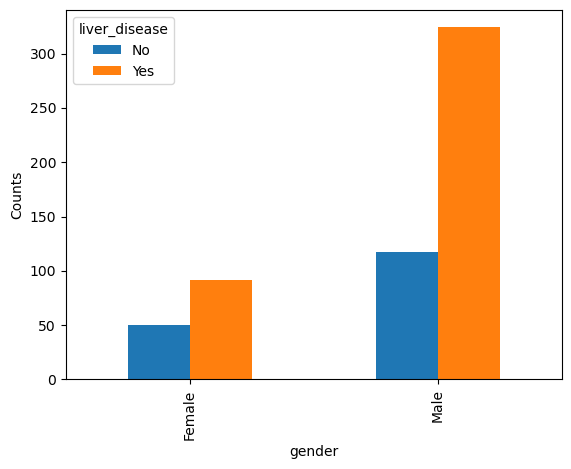

In [267]:
patient_data["liver_disease"] = patient_data["dataset"].apply(
    lambda dataset: "Yes" if dataset == 1 else "No"
)
patient_data.groupby("gender").liver_disease.value_counts().unstack().plot.bar()
plt.ylabel("Counts")

## Synthetic Data Generation

### SDV
Let's explore `SDV`, a library for synthetic data generation: 

In [268]:
from sdv.lite import SingleTablePreset
from sdv.metadata import SingleTableMetadata


metadata = SingleTableMetadata()
metadata.detect_from_dataframe(patient_data)

data_generator = SingleTablePreset(metadata, name="FAST_ML")
data_generator.fit(data=patient_data)

synthetic_data = data_generator.sample(num_rows=len(patient_data))
synthetic_data

/opt/conda/lib/python3.10/site-packages/rdt/transformers/categorical.py:329: FutureWarning: The 'FrequencyEncoder' transformer will no longer be supported in future versions of the RDT library. Please use the 'UniformEncoder' transformer instead.
  warnings.warn(


,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id,liver_disease
0,38,Male,10.115695,2.941720,395,236,312,6.631129,3.069221,0.984219,1,0,Yes
1,44,Male,7.901972,2.691352,485,146,306,6.101162,2.690942,0.513088,1,1,Yes
2,68,Male,17.550092,7.450946,653,326,617,6.185759,1.883869,0.566673,1,2,Yes
3,69,Male,0.400000,0.100000,628,10,10,6.359909,3.322110,1.217822,1,3,Yes
4,57,Male,1.364023,0.100000,239,33,135,6.530005,3.600876,1.088464,1,4,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,30,Male,19.182317,7.453156,644,10,10,8.080108,3.806403,1.071211,1,578,Yes
579,54,Male,5.845429,3.453339,63,10,10,4.794235,1.678242,1.001001,1,579,Yes
580,73,Male,3.915174,3.143086,1051,249,325,5.840546,2.372456,0.521491,1,580,Yes
581,70,Male,13.338579,5.491447,485,94,53,6.207086,3.729643,1.310537,1,581,Yes


## Generating Tabular Data

Let's start generating data for a single column, `age`, in a differentially private way. First, we represent the column as a histogram:

<Axes: xlabel='age'>

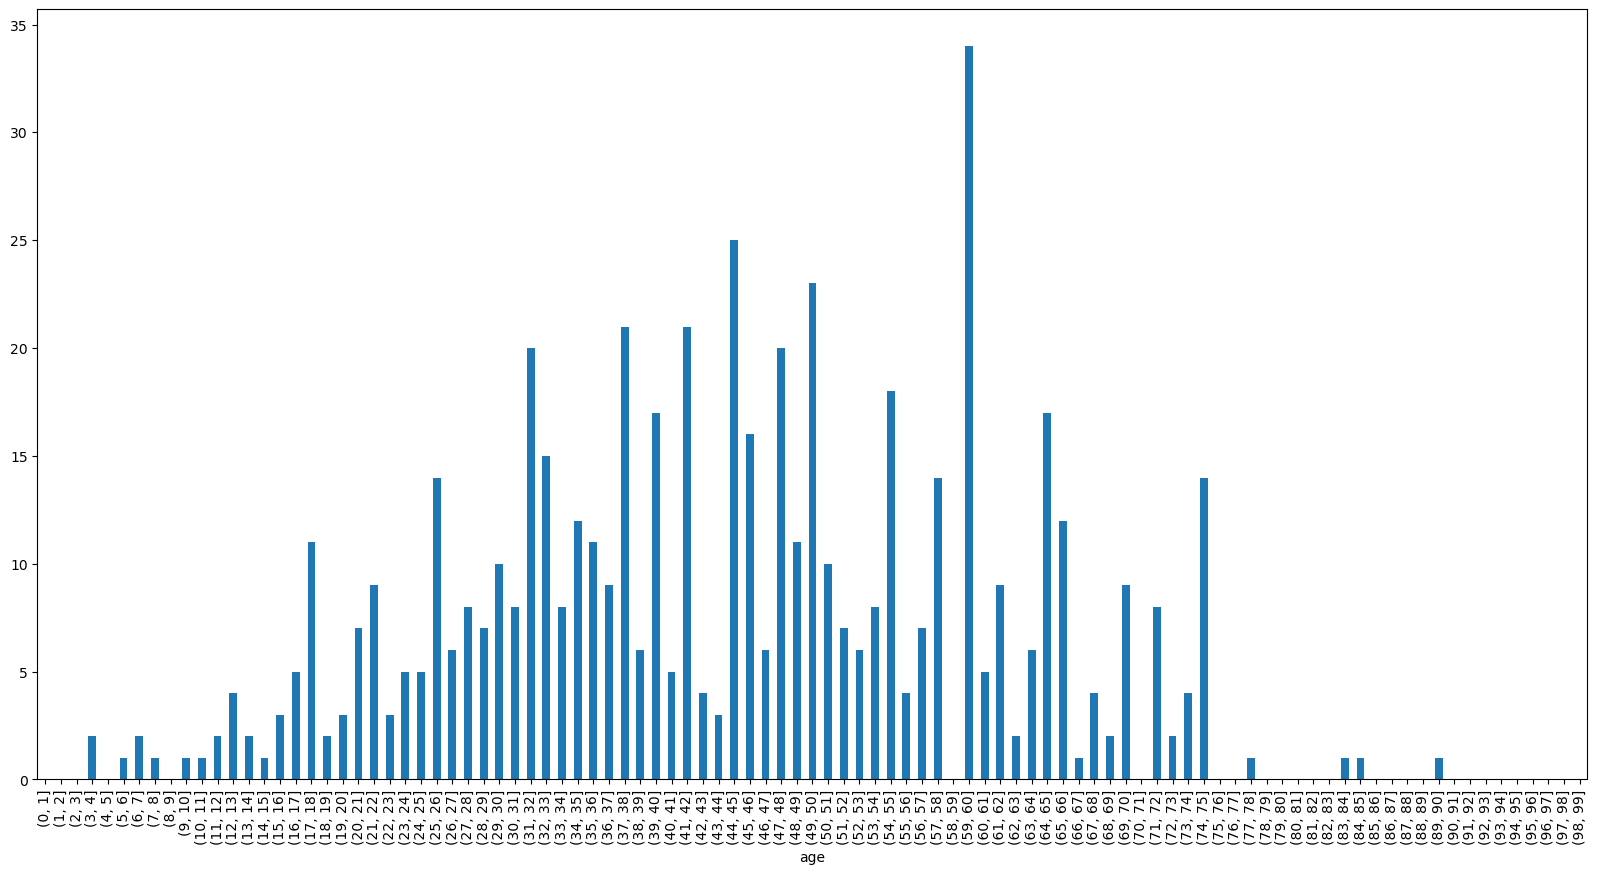

In [269]:
bin_limits: list[int] = list(range(0, 100))

patients_by_bin = healthcare_demo.group_by_bins(patient_data, "age", bin_limits)
age_counts_by_bin: pd.DataFrame = patients_by_bin.count()["age"]

age_counts_by_bin.plot.bar(figsize=(20, 10))

Now, we make our histogram representation differentially private, by adding Laplace noise and normalising:

age
(0, 1]      0.011587
(1, 2]      0.000000
(2, 3]      0.000000
(3, 4]      0.012334
(4, 5]      0.000000
              ...   
(94, 95]    0.006292
(95, 96]    0.006381
(96, 97]    0.004062
(97, 98]    0.000000
(98, 99]    0.000000
Name: age, Length: 99, dtype: float64

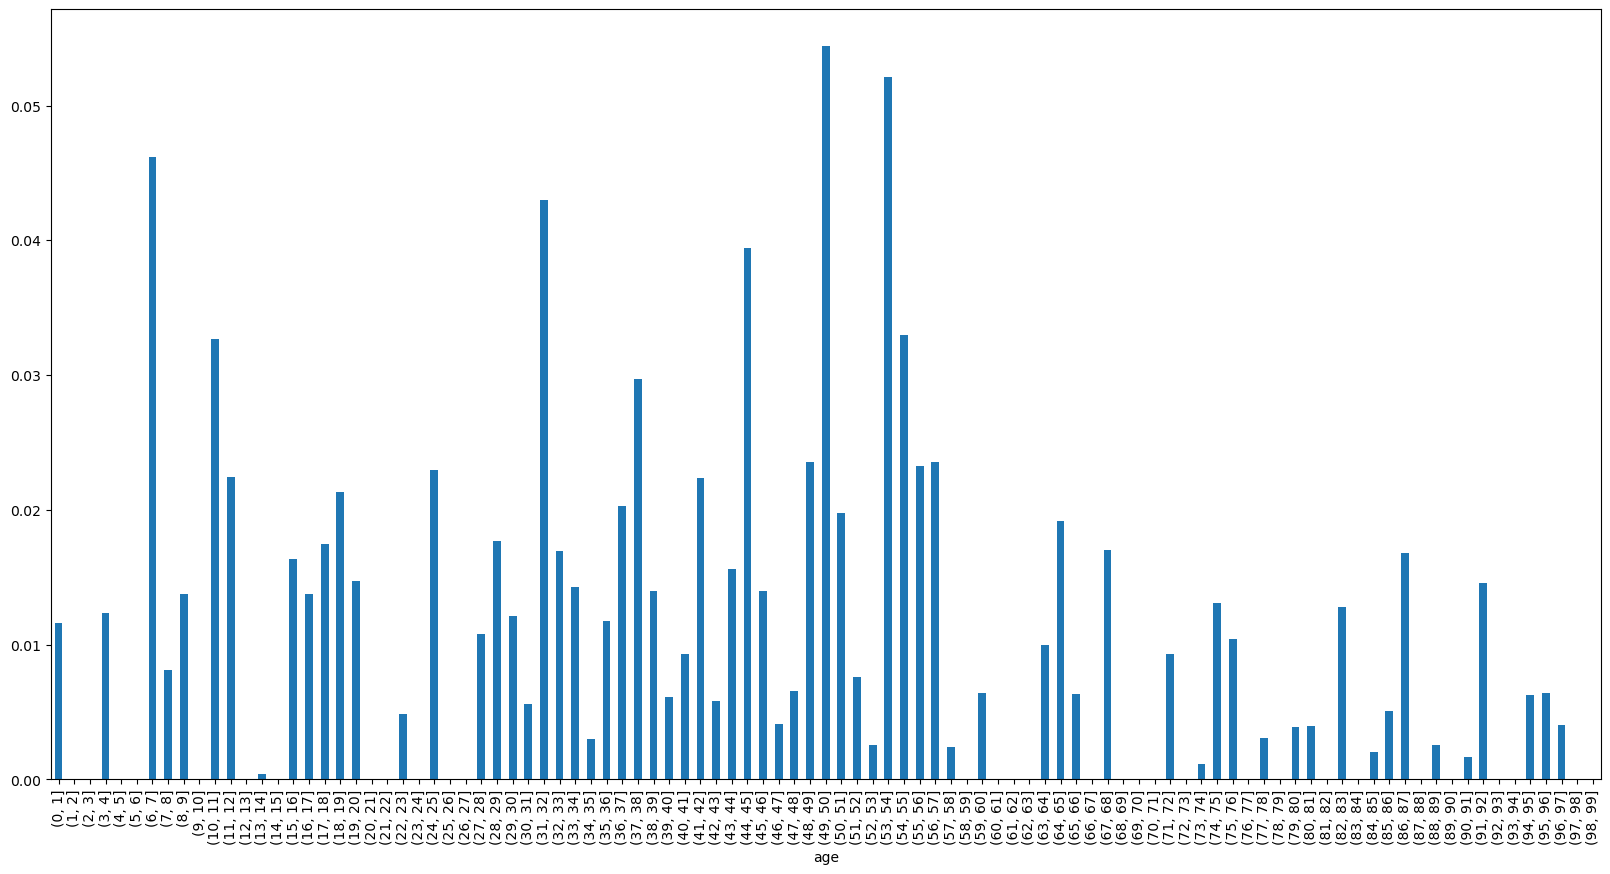

In [270]:
age_counts_by_bin_laplace: pd.Series = age_counts_by_bin.apply(
    lambda age_count: age_count
    + healthcare_demo.get_noise_using_laplace(count_sensitivity, privacy_budget)
)
age_counts_by_bin_laplace = age_counts_by_bin_laplace.clip(lower=0)

total_count: float = age_counts_by_bin_laplace.sum()
normalized_age_counts_by_bin: pd.Series = age_counts_by_bin_laplace.apply(
    lambda age_count: age_count / total_count
)

normalized_age_counts_by_bin.plot.bar(figsize=(20, 10))
normalized_age_counts_by_bin

Note the normalised plot and the original plot look similar. Now, its time to generate a synthetic dataset:

<Axes: xlabel='age'>

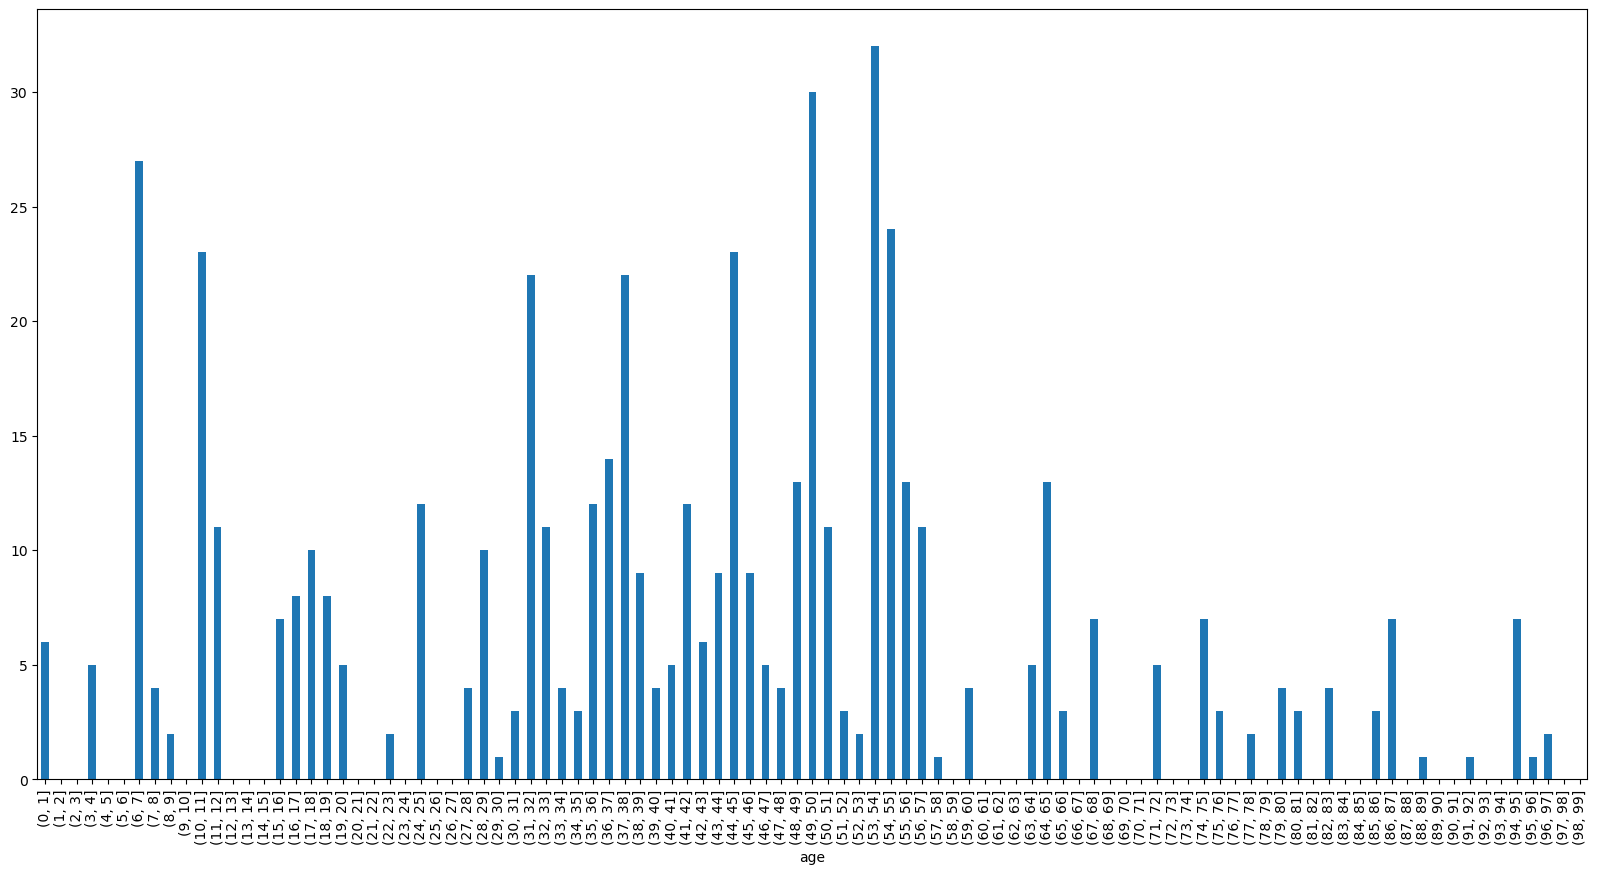

In [278]:
samples: int = len(patient_data) + healthcare_demo.get_noise_using_laplace(
    count_sensitivity, privacy_budget
)
probabilities: np.ndarray = normalized_age_counts_by_bin.values

bin_edges: list[str] = bin_values[1:]  # The intervals are right-inclusive.

synthetic_patients: pd.DataFrame = pd.DataFrame(
    healthcare_demo.generate_samples(int(samples), bin_edges, probabilities),
    columns=["age"],
)

healthcare_demo.group_by_bins(synthetic_patients, "age", bin_limits).count()["age"].plot.bar(figsize=(20, 10))


Let's gather some metrics, and compare them over the two datasets:

In [279]:
print(f"Real patients: {len(patient_data)}")
print(f'Synthetic samples: {len(synthetic_patients)}')
print(f"Mean age in real data: {patient_data['age'].mean()}")
print(f"Mean age in synthetic sample: {synthetic_patients['age'].mean()}")

range_minimum: int = 20
range_maximum: int = 60

print(
    f"Patients in range in real data: {healthcare_demo.query_patients_by_range('age', range_minimum, range_maximum, patient_data)}"
)

print(
    f"Patients in range in synthetic data: {healthcare_demo.query_patients_by_range('age', range_minimum, range_maximum, synthetic_patients)}"
)

Real patients: 583
Synthetic samples: 544
Mean age in real data: 44.74614065180103
Mean age in synthetic sample: 41.75
Patients in range in real data: 412
Patients in range in synthetic data: 351


## SQLSynthGen

`SQLSynthGen` is a tool for synthetic data generation in tabular format. First, let's create a replica of our `indian_liver_patient` table at the `db` database

In [272]:

%env SRC_DSN='postgresql://postgres@localhost/db'
%env DST_DSN='postgresql://postgres@localhost/db_replica'

!sqlsynthgen make-tables
!sqlsynthgen create-tables

env: SRC_DSN='postgresql://postgres@localhost/db'
env: DST_DSN='postgresql://postgres@localhost/db_replica'
Traceback (most recent call last):
  File "/opt/conda/bin/sqlsynthgen", line 5, in <module>
    from sqlsynthgen.main import app
  File "/opt/conda/lib/python3.10/site-packages/sqlsynthgen/main.py", line 16, in <module>
    from sqlsynthgen.make import make_src_stats, make_table_generators, make_tables_file
  File "/opt/conda/lib/python3.10/site-packages/sqlsynthgen/make.py", line 11, in <module>
    import snsql
  File "/opt/conda/lib/python3.10/site-packages/snsql/__init__.py", line 1, in <module>
    from .connect import from_connection, from_df
  File "/opt/conda/lib/python3.10/site-packages/snsql/connect.py", line 1, in <module>
    from .sql.private_reader import PrivateReader
  File "/opt/conda/lib/python3.10/site-packages/snsql/sql/__init__.py", line 1, in <module>
    from .private_reader import PrivateReader
  File "/opt/conda/lib/python3.10/site-packages/snsql/sql/priv

The `indian_liver_patient` table should now be available in the `db_replica` database. However, it is now empty:

In [273]:
print(len(patient_data["age"].value_counts()))

with pd.option_context('display.max_rows', None):
    print(patient_data["age"].value_counts())

72
age
60    34
45    25
50    23
42    21
38    21
32    20
48    20
55    18
65    17
40    17
46    16
33    15
58    14
75    14
26    14
35    12
66    12
18    11
49    11
36    11
51    10
30    10
62     9
70     9
22     9
37     9
34     8
28     8
72     8
31     8
54     8
52     7
57     7
21     7
29     7
53     6
39     6
27     6
64     6
47     6
41     5
61     5
24     5
25     5
17     5
56     4
43     4
13     4
68     4
74     4
16     3
44     3
23     3
20     3
63     2
14     2
73     2
69     2
12     2
4      2
7      2
19     2
6      1
8      1
84     1
85     1
15     1
78     1
11     1
67     1
10     1
90     1
Name: count, dtype: int64


In [274]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
    print(query_dataframe[["age", "gender"]].value_counts())

NameError: name 'query_dataframe' is not defined

**10** people are identifiable by their age. We can see this better in a plot:

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
    print(query_dataframe["age"].value_counts())

NameError: name 'query_dataframe' is not defined

We see 10 people have 51 years, but only 1 is female